In [1]:
# Custom Head Calssifier

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F

class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [2]:
# Load the saved model

save_dir = "Saved_Models/fine_tuned_ESM2_650M_model_with_custom_head"
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model_load = AutoModelForSequenceClassification.from_pretrained(save_dir, num_labels=2)
embedding_size = model_load.config.hidden_size
model_load.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)

# Load the trained weights
model_load.classifier.load_state_dict(torch.load(f"{save_dir}/custom_head.pt"))

# Move to GPU if needed
model_load = model_load.to("cuda:0")
model_load.eval()  # set to evaluation mode

Some weights of the model checkpoint at Saved_Models/fine_tuned_ESM2_650M_model_with_custom_head were not used when initializing EsmForSequenceClassification: ['classifier.fc1.bias', 'classifier.fc1.weight', 'classifier.fc2.bias', 'classifier.fc2.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at Saved_Models/fine_tuned_ESM2_650M_model_with_custom_head and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [3]:
# Check if CUDA is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



Using device: cuda


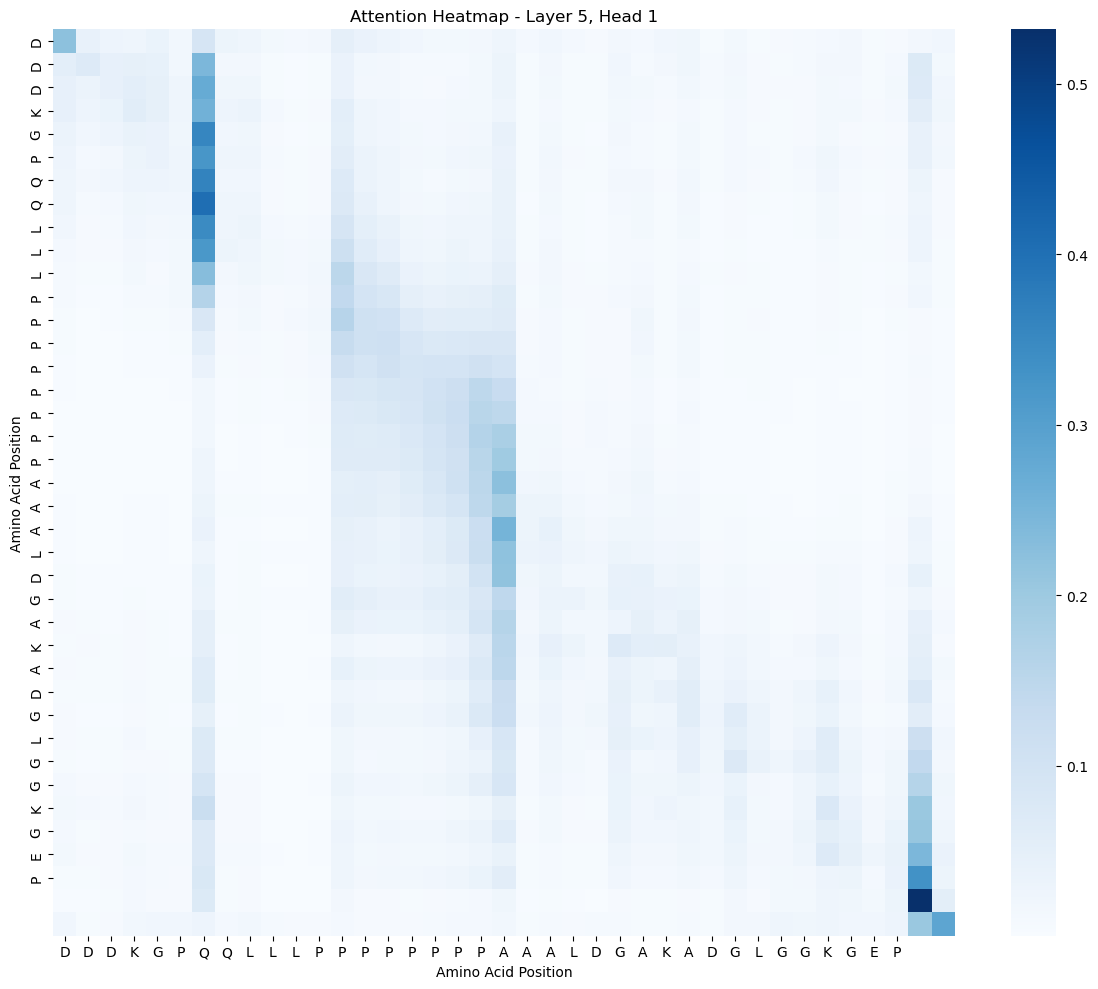

In [4]:
# Attention heatmaps

from transformers import EsmTokenizer, EsmModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
model=model_load

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Move model to CUDA
model = model.to(device)


# Your protein sequence
protein_sequence = "DDDKGPQQLLLPPPPPPPPAAALDGAKADGLGGKGEP"
# Tokenize
encoded = tokenizer(
    protein_sequence,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)
device='cuda'
# Move input tensors to the same device as model
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# Extract attention weights
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions

# Visualize attention from layer 6, head 0 (adjust as needed)
layer_idx = 5
head_idx = 1
attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    attention_matrix, 
    cmap='Blues',
    xticklabels=list(protein_sequence),
    yticklabels=list(protein_sequence)
)
plt.title(f'Attention Heatmap - Layer {layer_idx}, Head {head_idx}')
plt.xlabel('Amino Acid Position')
plt.ylabel('Amino Acid Position')
plt.tight_layout()
#plt.savefig('../Figures/Heat_Map', dpi=400)  # Save the figure
plt.show()

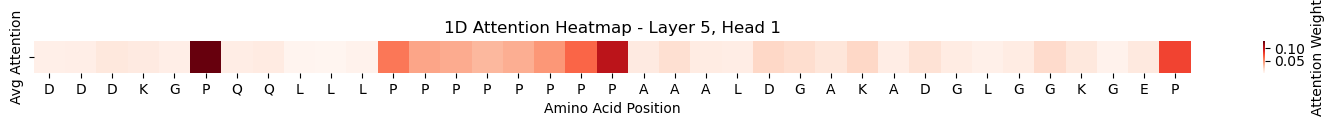

In [5]:
# 1D average attention heatmap

from transformers import EsmTokenizer, EsmModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Your protein sequence
protein_sequence = "DDDKGPQQLLLPPPPPPPPAAALDGAKADGLGGKGEP"
# Tokenize
encoded = tokenizer(
    protein_sequence,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move input tensors to the same device as model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# Extract attention weights
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions

# Get attention from specific layer and head
layer_idx = 5
head_idx = 1
attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

# Create 1D heatmap by averaging attention received by each position
# Skip special tokens (first and last positions are typically <cls> and <eos>)
protein_length = len(protein_sequence)
attention_1d = np.mean(attention_matrix[1:protein_length+1, 1:protein_length+1], axis=0)

# Create 1D heatmap
plt.figure(figsize=(15, 1.25))
sns.heatmap(
    attention_1d.reshape(1, -1), 
    cmap='Reds',
    xticklabels=list(protein_sequence),
    yticklabels=['Avg Attention'],
    cbar_kws={'label': 'Attention Weight'}
)
plt.title(f'1D Attention Heatmap - Layer {layer_idx}, Head {head_idx}')
plt.xlabel('Amino Acid Position')
plt.tight_layout()
#plt.savefig('../Figures/Heat_Map_GEKPYKCC', dpi=400)  # Save the figure
plt.show()